<span style="float: left;padding: 1.3em">![logo](https://github.com/gw-odw/odw-2024/blob/main/Tutorials/logo.png?raw=1)</span>

#  Gravitational Wave Open Data Workshop #7


#### Tutorial 3.3:  Searches for continuous gravitational waves with the frequency-Hough Transform



### Searching for continuous gravitational waves from isolated, asymmetricly rotating neutron stars


#### Searches for continuous waves from isolated, deformed neutron stars are broadly classified into three forms, depending on how much we know about the source: targeted (known position, rotational frequency and spin-down), directed (known position, unknown frequency/spin-down) and all-sky (all parameters unknown).

#### There are benefits and drawbacks to each kind of search -- see arXiv:2206.06447 for a recent review.

###### This tutorial will focus on a particular algorithm for all-sky searches for continuous gravitational waves: the frequency-Hough transform. This method maps points in the time/frequency plane of the detector to lines in the frequency/spin-down plane of the source. See arXiv:1407.8333 for more details.

#### Note: The frequency-Hough transform algorithm and its implementation for CW searches has been designed and implemented for real searches by the Virgo Rome group of the LVK collaboration

# Import stuff

In [1]:
# this will take a few minutes on first run, then should use cached files and be fast
!pip install pyhough
!pip install pyfstat

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.7/123.7 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.

In [2]:
import os
import pyfstat
import numpy as np
import pyhough
from pyhough import pm
from pyhough import hm
#### for some reason pm and hm need to be imported separately
# make sure to put these after the pyfstat import, to not break notebook inline plots
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.11/dist-packages/pyfstat/core.py:13: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal



# Simulate a CW signal and compute a spectrogram

Compute the spectrogram of a set of SFTs. This is useful to produce
visualizations of the Doppler modulation of a CW signal.


In [3]:
# general setup
label = "PyFstatExampleSpectrogram"
outdir = os.path.join("./tuto_A.3/PyFstat_example_data", label)
logger = pyfstat.set_up_logger(label=label, outdir=outdir)

In [4]:
# properties of the GW data
depth = 5 ## this is a measure of strength of the GW signal. Larger depth --> smaller GW amplitude

data_parameters = {
    "sqrtSX": 1e-23,
    "tstart": 1000000000,
    "duration": 0.4 * 365 * 86400,
    "detectors": "H1",
    "Tsft": 1800,
}

signal_parameters = {
    "F0": 100.0,
    "F1": -1e-9,
    "F2": 0,
    "Alpha": np.pi/2,
    "Delta": 0.0,
#     "tp": 0,#data_parameters["tstart"],
#     "asini": 0,#25.0,
#     "period": 0,#50 * 86400,
    "tref": data_parameters["tstart"],
    "h0": data_parameters["sqrtSX"] / depth,
    "cosi": 1.0,
}

In [5]:
# making data
data = pyfstat.Writer(
    label=label, outdir=outdir, **data_parameters, **signal_parameters
)
data.make_data()

25-04-15 17:35:00.089 pyfstat.core INFO    : Creating Writer object...


INFO:pyfstat.core:Creating Writer object...


25-04-15 17:35:00.092 pyfstat.utils.ephemeris INFO    : No /root/.pyfstat.conf file found. Will fall back to lal's automatic path resolution for files [earth00-40-DE405.dat.gz,sun00-40-DE405.dat.gz]. Alternatively, set 'earth_ephem' and 'sun_ephem' class options.


INFO:pyfstat.utils.ephemeris:No /root/.pyfstat.conf file found. Will fall back to lal's automatic path resolution for files [earth00-40-DE405.dat.gz,sun00-40-DE405.dat.gz]. Alternatively, set 'earth_ephem' and 'sun_ephem' class options.


25-04-15 17:35:00.117 pyfstat.make_sfts INFO    : Estimating required SFT frequency range from properties of signal to inject plus 59 extra bins either side (corresponding to default F-statistic settings).


INFO:pyfstat.make_sfts:Estimating required SFT frequency range from properties of signal to inject plus 59 extra bins either side (corresponding to default F-statistic settings).


25-04-15 17:35:00.159 pyfstat.make_sfts INFO    : Generating SFTs with fmin=99.94401438634598, Band=0.09935816377498738


INFO:pyfstat.make_sfts:Generating SFTs with fmin=99.94401438634598, Band=0.09935816377498738


25-04-15 17:35:00.162 pyfstat.make_sfts INFO    : Checking if we can reuse injection config file...


INFO:pyfstat.make_sfts:Checking if we can reuse injection config file...


25-04-15 17:35:00.165 pyfstat.make_sfts INFO    : ...no config file ./tuto_A.3/PyFstat_example_data/PyFstatExampleSpectrogram/PyFstatExampleSpectrogram.cff found.


INFO:pyfstat.make_sfts:...no config file ./tuto_A.3/PyFstat_example_data/PyFstatExampleSpectrogram/PyFstatExampleSpectrogram.cff found.


25-04-15 17:35:00.167 pyfstat.make_sfts INFO    : Writing config file: ./tuto_A.3/PyFstat_example_data/PyFstatExampleSpectrogram/PyFstatExampleSpectrogram.cff


INFO:pyfstat.make_sfts:Writing config file: ./tuto_A.3/PyFstat_example_data/PyFstatExampleSpectrogram/PyFstatExampleSpectrogram.cff


25-04-15 17:35:00.169 pyfstat.make_sfts INFO    : Checking if we can reuse existing SFT data file(s)...


INFO:pyfstat.make_sfts:Checking if we can reuse existing SFT data file(s)...


25-04-15 17:35:00.170 pyfstat.make_sfts INFO    : ...no SFT file matching './tuto_A.3/PyFstat_example_data/PyFstatExampleSpectrogram/H-7008_H1_1800SFT_PyFstatExampleSpectrogram-1000000000-12614400.sft' found. Will create new SFT file(s).


INFO:pyfstat.make_sfts:...no SFT file matching './tuto_A.3/PyFstat_example_data/PyFstatExampleSpectrogram/H-7008_H1_1800SFT_PyFstatExampleSpectrogram-1000000000-12614400.sft' found. Will create new SFT file(s).


25-04-15 17:35:00.172 pyfstat.utils.cli INFO    : Now executing: lalpulsar_Makefakedata_v5 --outSingleSFT=TRUE --outSFTdir="./tuto_A.3/PyFstat_example_data/PyFstatExampleSpectrogram" --outLabel="PyFstatExampleSpectrogram" --IFOs="H1" --sqrtSX="1e-23" --startTime=1000000000 --duration=12614400 --fmin=99.94401438634598 --Band=0.09935816377498738 --Tsft=1800 --injectionSources="./tuto_A.3/PyFstat_example_data/PyFstatExampleSpectrogram/PyFstatExampleSpectrogram.cff" --ephemEarth="earth00-40-DE405.dat.gz" --ephemSun="sun00-40-DE405.dat.gz"


INFO:pyfstat.utils.cli:Now executing: lalpulsar_Makefakedata_v5 --outSingleSFT=TRUE --outSFTdir="./tuto_A.3/PyFstat_example_data/PyFstatExampleSpectrogram" --outLabel="PyFstatExampleSpectrogram" --IFOs="H1" --sqrtSX="1e-23" --startTime=1000000000 --duration=12614400 --fmin=99.94401438634598 --Band=0.09935816377498738 --Tsft=1800 --injectionSources="./tuto_A.3/PyFstat_example_data/PyFstatExampleSpectrogram/PyFstatExampleSpectrogram.cff" --ephemEarth="earth00-40-DE405.dat.gz" --ephemSun="sun00-40-DE405.dat.gz"


25-04-15 17:35:02.457 pyfstat.make_sfts INFO    : Successfully wrote SFTs to: ./tuto_A.3/PyFstat_example_data/PyFstatExampleSpectrogram/H-7008_H1_1800SFT_PyFstatExampleSpectrogram-1000000000-12614400.sft


INFO:pyfstat.make_sfts:Successfully wrote SFTs to: ./tuto_A.3/PyFstat_example_data/PyFstatExampleSpectrogram/H-7008_H1_1800SFT_PyFstatExampleSpectrogram-1000000000-12614400.sft


25-04-15 17:35:02.460 pyfstat.make_sfts INFO    : Now validating each SFT file...


INFO:pyfstat.make_sfts:Now validating each SFT file...


In [6]:
logger.info("Loading SFT data and computing normalized power...")
freqs, times, sft_data = pyfstat.utils.get_sft_as_arrays(data.sftfilepath)
sft_power = sft_data["H1"].real ** 2 + sft_data["H1"].imag ** 2
normalized_power = (
    2 * sft_power / (data_parameters["Tsft"] * data_parameters["sqrtSX"] ** 2)
)

25-04-15 17:35:02.648 pyfstat INFO    : Loading SFT data and computing normalized power...


INFO:pyfstat:Loading SFT data and computing normalized power...


25-04-15 17:35:02.793 pyfstat.utils.sft INFO    : Loading 7008 SFTs from H1...


INFO:pyfstat.utils.sft:Loading 7008 SFTs from H1...


# Plot spectrogram with plot_triplets function

Here, we can make out two modulations. One is due to the instrinsic spin-down of the source, and the other is due to the relative motion of the earth around the sun w.r.t. the source.

In equations, the frequency evolution of the signal can be described as:

\begin{equation}
f(t) = \left(f_0+\dot{f}(t-t_0)\right)\left(1+\frac{\vec{v}\cdot\hat{n}}{c}\right) \tag{1}
\end{equation}
where $f_0$ is the emitted GW frequency at the time $t_0$, $\vec{v}$ is the velocity of the detector, $\hat{n}$ is the unit vector between the earth and the source.

$f(t)$ is the measured frequency at time $t$, and is what is plotted in the time/freuqency maps below.

We are interested in obtaining the source parameters, that is, the GW frequency $f_0$ and the spin-down $\dot{f}$.



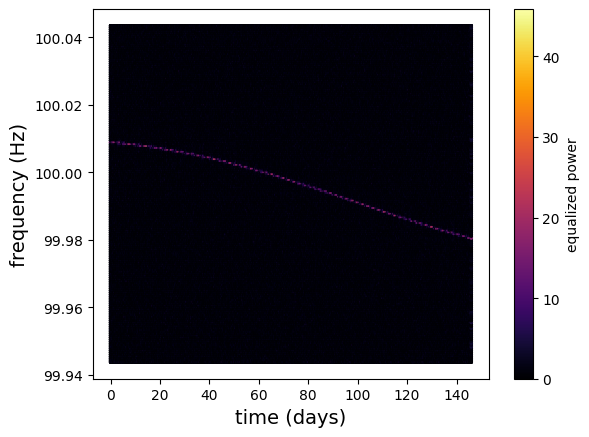

In [7]:
flat_times,flat_freqs,flat_pows = pyhough.pm.flatten_spectrogram(times["H1"],freqs,normalized_power)
pyhough.pm.python_plot_triplets((flat_times-flat_times[0])/86400,flat_freqs,flat_pows,'.',label='equalized power')
plt.xlabel('time (days)',size=14)
plt.ylabel('frequency (Hz)',size=14);

# Create peakmap from spectrogram

Here, we take the spectrogram computed in PyFstat, and, in each Fast Fourier Transform (that is, at each time in the spectrogram), select local maxima above a chosen threshold. The local maxima criteria reduce the impact of noise lines that may pollute multiple adjacent frequency bins.

We call the resulting thresholded spectrogram a "peakmap", where each surviving time/frequency pixel is called a "peak".

#### Setting threshold on peak selection to be:

In [8]:
threshold = 3 # need to apply a threshold on equalized power and select maxima above this threshold to run Hough
pm_times,pm_freqs,pm_pows,index = pyhough.pm.make_peakmap_from_spectrogram(times["H1"],freqs,normalized_power,threshold)

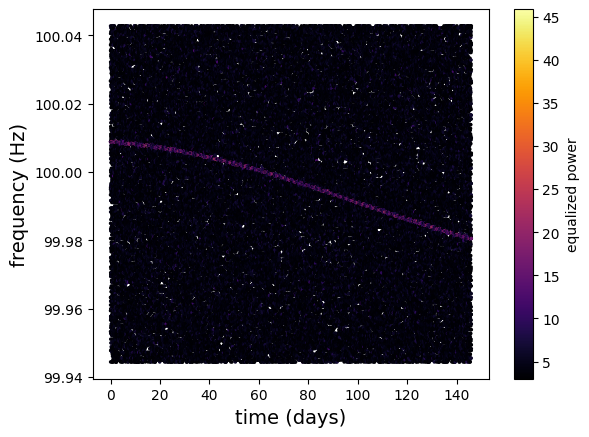

In [9]:
pyhough.pm.python_plot_triplets((pm_times-pm_times[0])/86400,pm_freqs,pm_pows,'.',label='equalized power')
plt.xlabel('time (days)',size=14)
plt.ylabel('frequency (Hz)',size=14);
# plt.ylim([99.98,100.02])

# Create source position vector and get detector velocities for Dopp Corr

In [10]:
# source position and detector velocities
position = [signal_parameters["Alpha"], signal_parameters["Delta"]]
vec_n = pyhough.pm.astro2rect(position,1)
ts,vs = pyhough.pm.get_detector_velocities(data)
Nts = len(ts)

25-04-15 17:37:15.334 pyfstat.utils.ephemeris INFO    : No /root/.pyfstat.conf file found. Will fall back to lal's automatic path resolution for files [earth00-40-DE405.dat.gz,sun00-40-DE405.dat.gz]. Alternatively, set 'earth_ephem' and 'sun_ephem' class options.


INFO:pyfstat.utils.ephemeris:No /root/.pyfstat.conf file found. Will fall back to lal's automatic path resolution for files [earth00-40-DE405.dat.gz,sun00-40-DE405.dat.gz]. Alternatively, set 'earth_ephem' and 'sun_ephem' class options.


# Remove Doppler shift from peakmap

To search for a continuous wave coming from a particular sky location, we "point" our detector by correcting the data for the Doppler shift induced by the relative motion of earth and the source. In this method, the Doppler correction is a shifting of the time/frequency peaks in the peakmap for a given sky location.

Essentially, this corresponds to the following

\begin{equation}
\frac{f(t)}{\left(1+\frac{\vec{v}\cdot\hat{n}}{c}\right)} = f_0 +\dot{f}(t-t_0) \tag{2}
\end{equation}

Now, the new frequency is simply:

\begin{equation}
f_{\rm new}(t) = f_0 + \dot{f}(t-t_0)
\end{equation}

and we can apply the frequency-Hough Transform to search for this modulation.




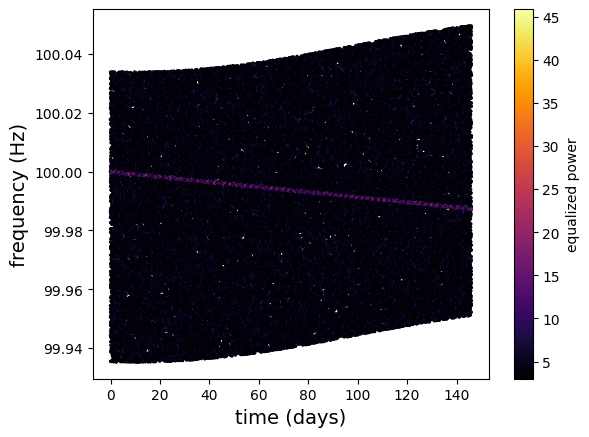

In [11]:
pm_freqs_undop = pyhough.pm.remove_doppler_from_peakmap(pm_times,pm_freqs,index,vec_n,vs,Nts) # Eq. 2
pyhough.pm.python_plot_triplets((pm_times-pm_times[0])/86400,np.array(pm_freqs_undop),pm_pows,'.',label='equalized power')
# plt.ylim([99.989,100.002]);
plt.xlabel('time (days)',size=14)
plt.ylabel('frequency (Hz)',size=14);

# Analysis and relevant signal parameters

In [12]:
alltimes = times["H1"] ### the times of the analysis
Tsft = data_parameters["Tsft"] # the FFT length used
df = 1/Tsft # the frequency bin size
Tobs = data_parameters["duration"] # the duration of the peakmap in seconds
ref_perc_time = 0.5 * 100 # reference time for the Hough at which f0 is determined, set any number between 0 (beginning), 100 (end)
sig_fdot = signal_parameters['F1'] #spin-down of injected signal
dsd = 1/(Tsft*Tobs) # step in spin-down: dsd = df / Tobs
sdgrid = pyhough.hm.make_sd_grid(sig_fdot,dsd) ## grid of spin-downs to search over

# Run frequency-Hough on Doppler corrected peakmap and plot Hough map


The input is the time/frequency peakmap, which is simply a collection of ones. For given choices of $\dot{f}$, we solve for $f_0$

\begin{equation}
f_0 = f_{\rm new}-\dot{f}(t-t_0)
\end{equation}

We thus need to specify a range of $\dot{f}$ values with a particular spacing, given by:

\begin{equation}
\delta\dot{f} = df/T_{\rm obs}
\end{equation}
where $\delta f=1/T_{\rm FFT}$ and $T_{\rm FFT}$ is the FFT length (1800 s in this case), and specify a maximum and minimum $\dot{f}$ to search over.

The Hough sums ones along the time/frequency tracks of the signals, NOT the equalized power on the color axis that is seen in the peakmap plots

The output of this code $\texttt{hmap_from_pm}$ is a 2-dimensional histogram in the $f_0$/$\dot{f}$ plane of the source.

In [13]:
hmap_from_pm = pyhough.hm.hfdf_hough(pm_times,pm_freqs_undop,Tsft,sdgrid,ref_perc_time)
fs_for_hmap_from_pm = np.arange(np.min(pm_freqs_undop),np.max(pm_freqs_undop),df)

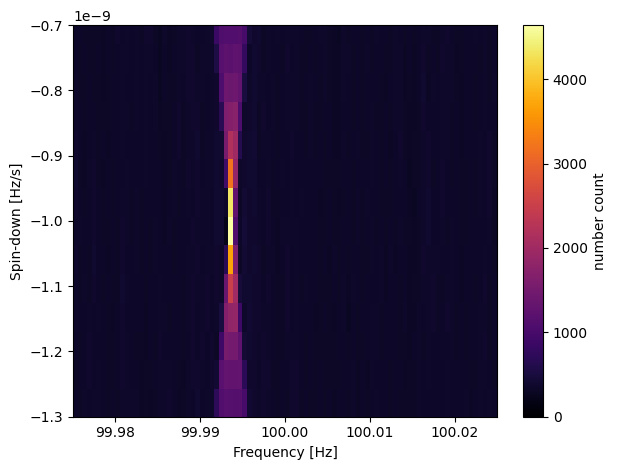

In [14]:
fig, ax = plt.subplots()#figsize=(0.8 * 16, 0.8 * 9))
ax.set(ylabel="Spin-down [Hz/s]", xlabel=r"Frequency [Hz]")#, ylim=(99.98, 100.02))
c = ax.pcolormesh(
    fs_for_hmap_from_pm,
    sdgrid,
    hmap_from_pm,
    cmap="inferno",
    shading="nearest",
)
fig.colorbar(c, label="number count")
plt.tight_layout()
ax.set(ylim=(sig_fdot*1.3,-0.7e-9));
ax.set(xlim=(99.975,100.025));
# plt.savefig('hm_map.jpg',format='png',dpi=400)

Q1: Why are there seemingly negative slopes of the lines in this map? Can you guess which parameter you need to change to obtain all positive slopes or a mix of positive and negative sloped lines?

Q2: If the true signal frequency and spin-down are  F0 and F1, respectively, why are there multiple pixels in this map surrounding the true values?

# Apply wrong Doppler correction to peakmap, run Hough, and plot

In [15]:
wrong_position = [np.pi/4, np.pi/5]
wrong_vec_n = pyhough.pm.astro2rect(wrong_position,1)

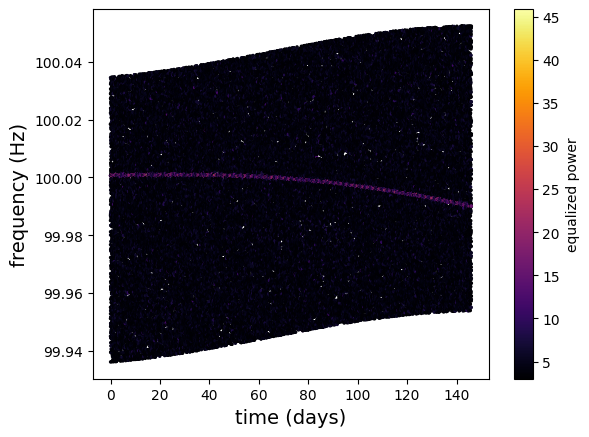

In [16]:
pm_freqs_undop_wrong = pyhough.pm.remove_doppler_from_peakmap(pm_times,pm_freqs,index,wrong_vec_n,vs,Nts)
pyhough.pm.python_plot_triplets((pm_times-pm_times[0])/86400,np.array(pm_freqs_undop_wrong),pm_pows,'.',label='equalized power')
# plt.ylim([99.989,100.002]);
plt.xlabel('time (days)',size=14)
plt.ylabel('frequency (Hz)',size=14);

Q3: Do you see the difference between using the wrong and correct source positions to correct the peakmap? What can you conclude about the ability of this method to localize sources in the sky?

Q4: What do you think will happen to a monochromatic noise line after the Doppler correction is applied? Is this good or not? Why?



In [17]:
#### run Hough
hmap_wrong_pos = pyhough.hm.hfdf_hough(pm_times,pm_freqs_undop_wrong,Tsft,sdgrid,ref_perc_time)
fs_for_hmap_from_spec_wrong_position = np.arange(np.min(pm_freqs_undop_wrong),np.max(pm_freqs_undop_wrong),df)

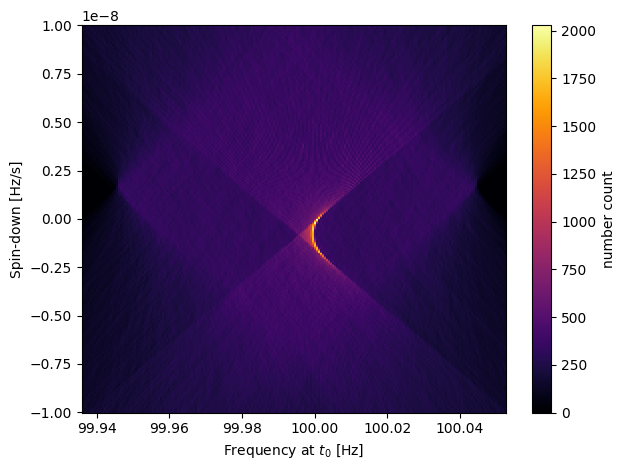

In [18]:
fig, ax = plt.subplots()#figsize=(0.8 * 16, 0.8 * 9))
ax.set(ylabel="Spin-down [Hz/s]", xlabel=r"Frequency at $t_0$ [Hz]")#, ylim=(99.98, 100.02))
c = ax.pcolormesh(
    fs_for_hmap_from_spec_wrong_position,
    sdgrid,
    hmap_wrong_pos,
    cmap="inferno",
    shading="nearest",
)
fig.colorbar(c, label="number count")
plt.tight_layout()
# ax.set(ylim=(sig_fdot*2,-sig_fdot*1.1));

Q5: Compare the peak number count at the source frequency and spin-down in this Hough map and the one run on the properly corrected peakmap. Why is there a reduction in the number count?



In [19]:
# %reset